In [246]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns
from copy import deepcopy

In [247]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [248]:
def inertia_sil(doc_topic, xline=None):
    output = []
    sill = []

    for i in range(2,20):
        model = KMeans(n_clusters=i)
        model.fit(doc_topic)
        output.append(model.inertia_)
        sill.append(silhouette_score(doc_topic, labels=model.labels_))

    fig, ax = plt.subplots()
    #plt.plot(range(2,11), output)
    l1, = ax.plot(range(2,20), output, linestyle='-', color='green')
    if xline:
        ax.vlines(x=xline, ymin=0, ymax=10, color='red', linestyle='--')
    ax2 = ax.twinx()
    l2, = ax2.plot(range(2,20), sill)
    plt.xticks(range(2,20));
    plt.title('K-Means inertia over 2-19 Ks')
    ax.set_xlabel('K')
    ax.set_ylabel('Inertia')
    ax2.set_ylabel('Silhouette Score')
    plt.legend(handles = [l1, l2],
               labels = ['Inertia', 'Silhouette Score'],
               loc='center right')
    fig.savefig('graphics/plottemp.jpg')

In [296]:
def show_variance_explained_plots(pca):
    
    var_exp_array = pca.explained_variance_ratio_
    n_comps = var_exp_array.shape[0] 
    
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    ax[0].fill_between(range(n_comps), var_exp_array)
    ax[0].set_title('Variance Explained by Nth Principal Component')
    
    ax[1].fill_between(range(n_comps), np.cumsum(var_exp_array))
    ax[1].set_title('Cumulative Variance Explained by N Components')
    
    plt.show()

In [249]:
dialog = pd.read_csv('tng_all_dialog3.csv', index_col=0)
dialog.shape

(70172, 5)

In [250]:
dialog.head()

,episode,character,dialog,season,character_raw
0,102,picard,That was an incredible program.,1,PICARD V.O.
1,102,picard,I am glad you approve. I have always found the...,1,PICARD V.O.
2,102,picard,"Worf, we were strolling barefoot along the bea...",1,PICARD V.O.
3,102,picard,(groping) It was... very stimulating.,1,PICARD V.O.
4,102,picard,I should take my own advice and use it to rela...,1,PICARD V.O.


In [251]:
dialog.character.value_counts()[:10]

picard     13820
riker       8129
data        6766
geordi      4961
worf        4157
beverly     3645
troi        3580
wesley      1487
pulaski      643
tasha        572
Name: character, dtype: int64

In [253]:
#separate out top 5 characters by dialog
char_dialog = {}
for character in dialog.character.value_counts()[:5].index:
    char_dialog[character] = deepcopy(dialog[dialog.character == character])

In [254]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=ENGLISH_STOP_WORDS)

## Identify topics for 'Picard'

In [255]:
doc_word_matrix = vectorizer.fit_transform(char_dialog['picard'].dialog)

In [256]:
doc_word_matrix

<13820x4086 sparse matrix of type '<class 'numpy.float64'>'
	with 138921 stored elements in Compressed Sparse Row format>

In [257]:
doc_topic_matrix.shape

(13820, 10)

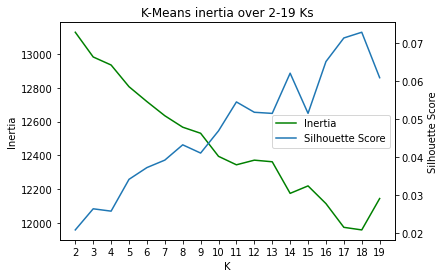

In [234]:
#no decomposition
inertia_sil(doc_word_matrix)

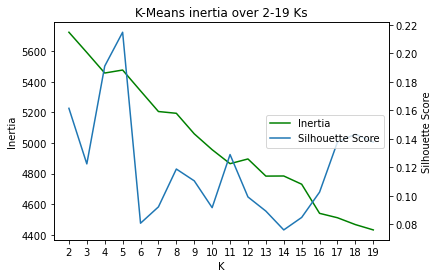

In [235]:
nmf = TruncatedSVD(n_components=100)
doc_topic_matrix = nmf.fit_transform(doc_word_matrix)
inertia_sil(doc_topic_matrix) #100 component NMF

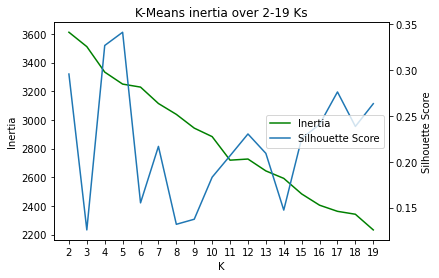

In [236]:
nmf = TruncatedSVD(n_components=50)
doc_topic_matrix = nmf.fit_transform(doc_word_matrix)
inertia_sil(doc_topic_matrix) #50 component NMF

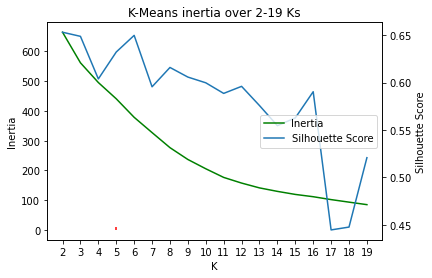

In [297]:
svd = TruncatedSVD(n_components=10)
doc_topic_matrix = svd.fit_transform(doc_word_matrix)
inertia_sil(doc_topic_matrix, xline=5) #25 component NMF
plt.savefig('Kmeans-picard')

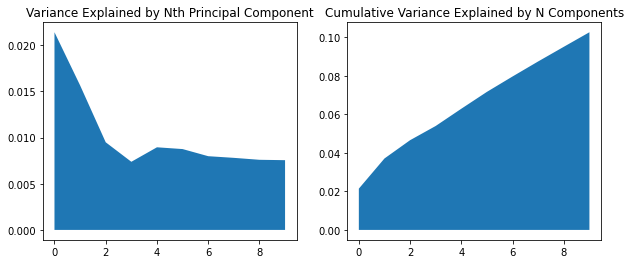

In [298]:
show_variance_explained_plots(svd)

In [259]:
km = KMeans(n_clusters=5)

In [260]:
km.fit(doc_topic_matrix)

KMeans(n_clusters=5)

In [261]:
clusters = km.predict(doc_topic_matrix)
clusters.shape

(13820,)

In [262]:
doc_topic_matrix.shape

(13820, 10)

In [263]:
x = char_dialog['picard']
x.loc['cluster'] = clusters

In [264]:
km.inertia_

710.9974615209744

In [265]:
x.cluster.value_counts()

1    12474
3      480
4      358
0      348
2      160
Name: cluster, dtype: int64

In [266]:
x.cluster.value_counts(normalize=True)

1    0.902605
3    0.034732
4    0.025904
0    0.025181
2    0.011577
Name: cluster, dtype: float64

In [274]:
x[x.cluster==3].head(100)


,episode,character,dialog,season,character_raw,cluster
60,102,picard,Sir... ?,1,PICARD,3
66,102,picard,"Have I done something wrong, sir?",1,PICARD,3
174,102,picard,Sir?,1,PICARD,3
181,102,picard,"(surprised) That's right, sir.",1,PICARD,3
530,102,picard,"Aye, sir.",1,PICARD,3
...,...,...,...,...,...,...
206,125,picard,"It is... good to see you, too, sir.",1,PICARD,3
330,125,picard,"Nothing, sir.",1,PICARD,3
332,125,picard,"Who, sir?",1,PICARD,3
335,125,picard,"No, sir.",1,PICARD,3


In [218]:
dialog[dialog.character == 'picard'].sample(10)

,episode,character,dialog,season,character_raw
190,242,picard,All those years you spent as a child... buildi...,6,PICARD
58,127,picard,Captain?,2,PICARD
108,109,picard,Captain... what's wrong?,1,PICARD
30,166,picard,How about Mister Picard?,3,PICARD
13,215,picard,"Captain, what's wrong?",5,PICARD
157,111,picard,We've completed a full subspace scan of the sh...,1,PICARD
200,171,picard,(groping) A figure of speech... I was trying t...,3,PICARD
247,195,picard,A prescription. A glass of warm milk and eight...,4,PICARD
290,154,picard,(continuing) We could arrange passage aboard a...,3,PICARD
72,104,picard,"Tasha... I was just with Tasha, in the shuttle...",1,PICARD


## Identify topics for Riker

In [275]:
doc_word_matrix = vectorizer.fit_transform(char_dialog['riker'].dialog)

In [276]:
doc_word_matrix

<8129x3684 sparse matrix of type '<class 'numpy.float64'>'
	with 82138 stored elements in Compressed Sparse Row format>

In [277]:
doc_word_matrix.shape

(8129, 3684)

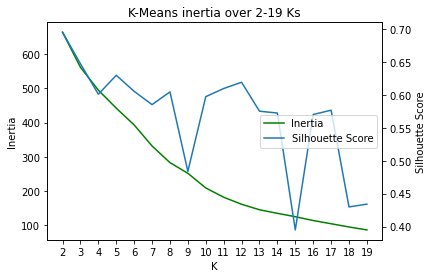

In [279]:
svd = TruncatedSVD(n_components=10)
doc_topic_matrix = svd.fit_transform(doc_word_matrix)
inertia_sil(doc_topic_matrix) #25 component NMF
plt.savefig('Kmeans-riker')

In [280]:
km = KMeans(n_clusters=5)

In [281]:
km.fit(doc_topic_matrix)

KMeans(n_clusters=5)

In [282]:
clusters = km.predict(doc_topic_matrix)
clusters.shape

(8129,)

In [285]:
y = char_dialog['riker']
y.loc[:,'cluster'] = clusters

In [286]:
y

,episode,character,dialog,season,character_raw,cluster
200,102,riker,(groping) A figure of speech... I was trying t...,1,RIKER'S VOICE,0
201,102,riker,"Ah. Then ""to burn the midnight oil"" implies la...",1,RIKER'S VOICE,0
202,102,riker,That's right.,1,RIKER'S VOICE,0
203,102,riker,I am curious. What is the etymology of that id...,1,RIKER'S VOICE,0
205,102,riker,"Commander Data, welcome aboard -- it's good to...",1,RIKER,0
...,...,...,...,...,...,...
840,277,riker,Come in.,7,RIKER,0
842,277,riker,Not at all. Have a seat.,7,RIKER,0
845,277,riker,Come.,7,RIKER,0
846,277,riker,(continuing) Captain. Is there a problem?,7,RIKER,0


In [287]:
km.inertia_

451.714741148219

In [288]:
y.cluster.value_counts()

0    7184
4     272
1     258
2     218
3     197
Name: cluster, dtype: int64

In [289]:
y.cluster.value_counts(normalize=True)

0    0.883750
4    0.033460
1    0.031738
2    0.026818
3    0.024234
Name: cluster, dtype: float64

In [295]:
y[y.cluster==3].head(100)


,episode,character,dialog,season,character_raw,cluster
214,102,riker,Yes...,1,RIKER,3
220,102,riker,Yes.,1,RIKER,3
293,102,riker,(excited) Yes... yes...,1,RIKER,3
125,103,riker,Yes... yes... I think he's...,1,RIKER,3
293,103,riker,(excited) Yes... yes...,1,RIKER,3
...,...,...,...,...,...,...
220,172,riker,Yes.,3,RIKER,3
355,172,riker,"Oh, most definitely yes.",3,RIKER,3
130,174,riker,Yes... Data... yes...,3,RIKER,3
250,174,riker,"(lightly) Yes, sir.",3,RIKER,3
